# Learning curve
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Fitting random forest](#Fit-random-forest-and-run-10-fold-CV-validation)
3. [Feature importance](#Feature-importance)

In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
print('Added to PYTHONPATH')

Added to PYTHONPATH


In [2]:
import argparse
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, learning_curve

import composition as comp
import composition.analysis.plotting as plotting

# Plotting-related
sns.set_palette('muted')
sns.set_color_codes()
color_dict = {'P': 'b', 'He': 'g', 'Fe': 'm', 'O': 'r'}
%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Data preprocessing
1. Load simulation dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets

In [3]:
df_sim, cut_dict_sim = comp.load_dataframe(type_='sim', config='IT73', return_cut_dict=True)
selection_mask = np.array([True] * len(df_sim))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict_sim[key]

df_sim = df_sim[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
X_train_sim, X_test_sim, y_train_sim, y_test_sim, le = comp.get_train_test_sets(
    df_sim, feature_list, comp_class=True, train_he=True, test_he=True)

print('number training events = ' + str(y_train_sim.shape[0]))
print('number testing events = ' + str(y_test_sim.shape[0]))

/home/jbourbeau/cr-composition/composition/load_dataframe.py:88: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))
/home/jbourbeau/cr-composition/composition/load_dataframe.py:89: RuntimeWarning: divide by zero encountered in log10
  df['log_NHits_1_30'] = np.nan_to_num(np.log10(df['NHits_1_30']))


training features = ['lap_log_energy', 'lap_cos_zenith', 'log_NChannels_1_30', 'nchannels_nhits_ratio', 'lap_likelihood', 'log_NHits_1_30', 'StationDensity', 'stationdensity_charge_ratio', 'nchannels_nhits_ratio', 'log_s50', 'log_s80', 'log_s125', 'log_s180', 'log_s250', 'log_s500', 'lap_beta']
number training events = 145932
number testing events = 62543


## Feature selection

In [6]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
pipeline = comp.get_pipeline('RF')
sfs = SFS(pipeline, 
          k_features=6, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          print_progress=True,
          cv=3,
          n_jobs=10)
sfs = sfs.fit(X_train_sim, y_train_sim)

Features: 6/6

## Feature transform

In [7]:
X_train_sim = sfs.transform(X_train_sim)
X_test_sim = sfs.transform(X_test_sim)

## Produce 10-fold CV learning curve

[learning_curve] Training set sizes: [ 13133  26267  39401  52535  65669  78802  91936 105070 118204 131338]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  .................................

[Parallel(n_jobs=20)]: Done  33 out of 100 | elapsed:   36.2s remaining:  1.2min


[CV] ....................................... , score=0.738299 -   1.5s
[CV]  ................................................................
[CV] ....................................... , score=0.733639 -   2.1s
[CV]  ................................................................
[CV] ....................................... , score=0.737066 -   1.4s
[CV]  ................................................................
[CV] ....................................... , score=0.732817 -   1.3s
[CV]  ................................................................
[CV] ....................................... , score=0.737340 -   0.9s
[CV]  ................................................................
[CV] ....................................... , score=0.731172 -   1.7s
[CV]  ................................................................
[CV] ....................................... , score=0.735969 -   1.7s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=20)]: Done  67 out of 100 | elapsed:  1.1min remaining:   33.2s


[CV] ....................................... , score=0.736723 -   1.4s
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................................... , score=0.735832 -   1.1s
[CV]  ................................................................
[CV] ....................................... , score=0.738984 -   1.1s
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................................... , score=0.737134 -   1.1s
[CV] ....................................... , score=0.738162 -   1.0s
[CV] ....................................... , score=0.736106 -   0.8s
[CV] ....................................... , score=0.735147 -   0.7s
[CV] ....................................... , score=0.734256 -   0.8s
[CV] .

[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:  1.7min finished


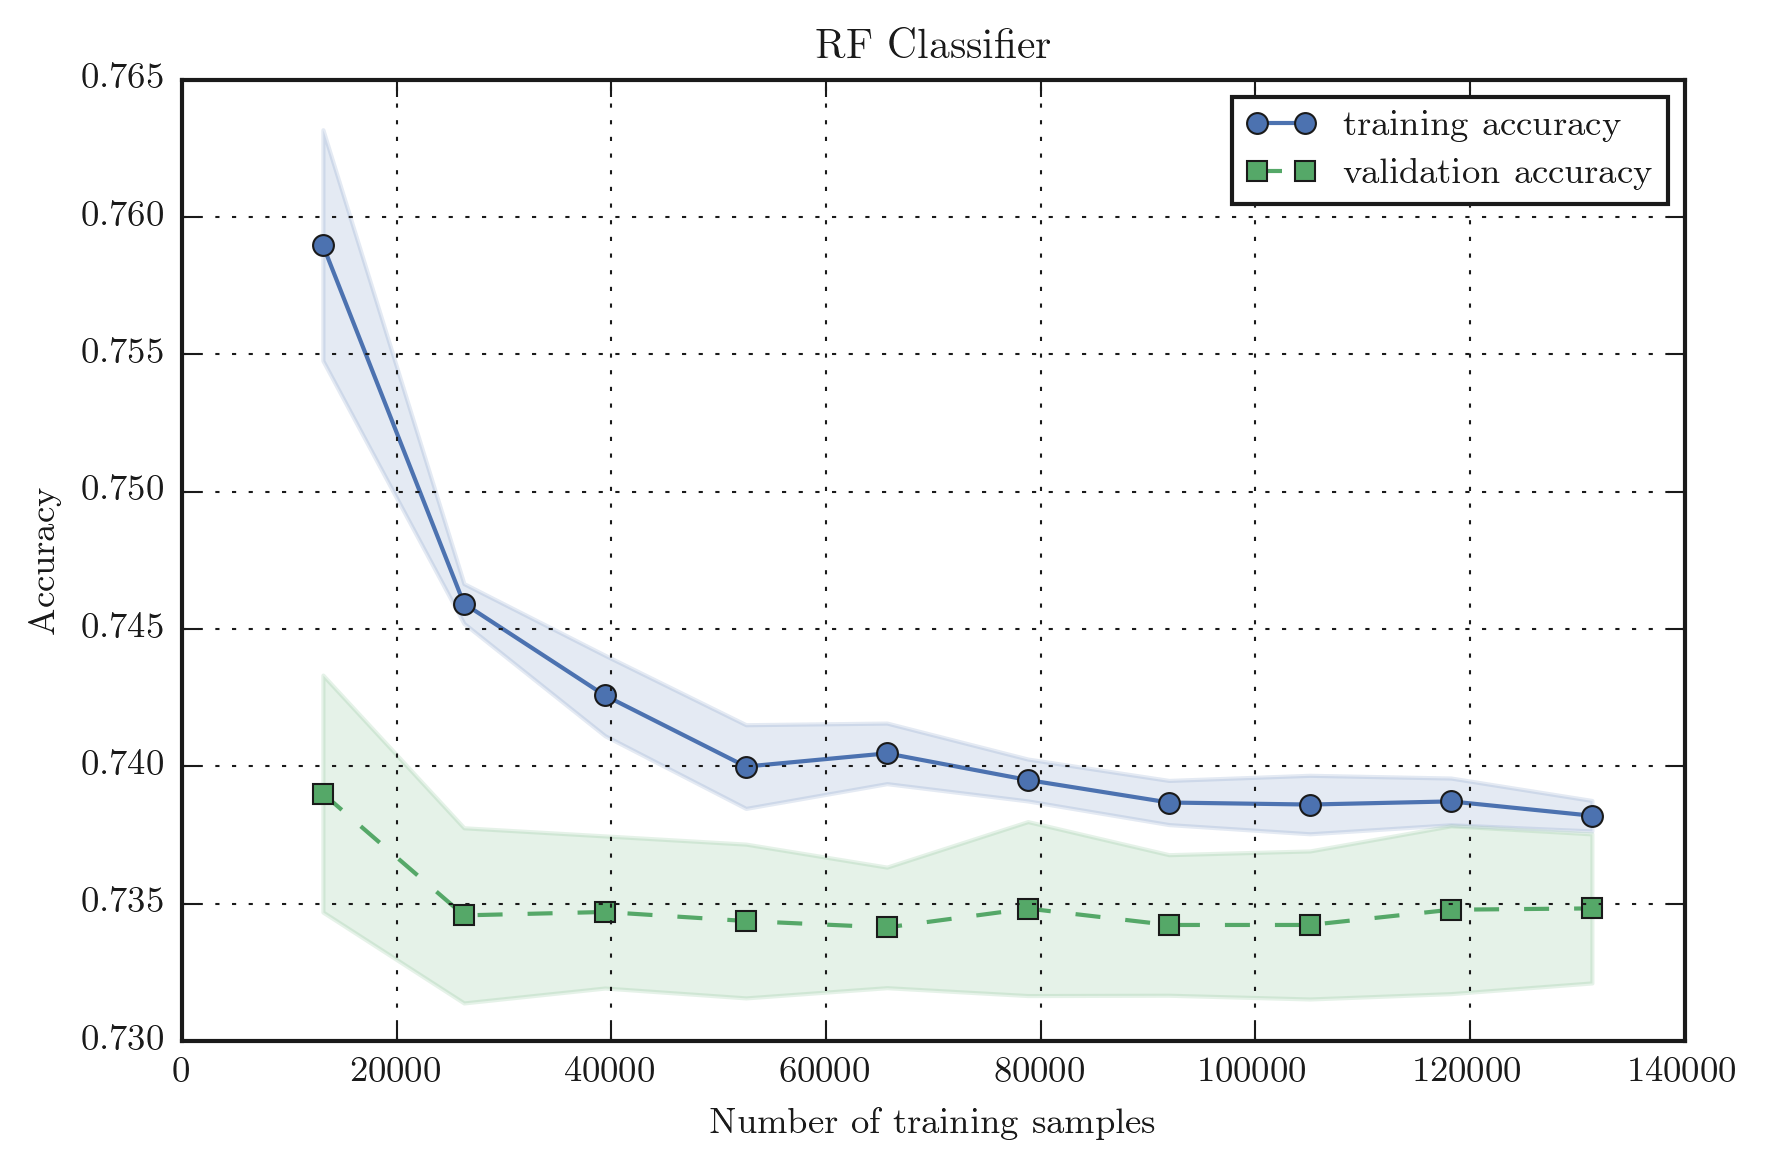

In [8]:
pipeline = comp.get_pipeline('RF')

train_sizes, train_scores, test_scores =\
    learning_curve(estimator=pipeline,
                   X=X_train_sim,
                   y=y_train_sim,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   cv=10,
                   n_jobs=20,
                   verbose=3)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='b', linestyle='-',
         marker='o', markersize=5,
         label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='b')

plt.plot(train_sizes, test_mean,
         color='g', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='g')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.title('RF Classifier')
plt.legend()
# plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

In [11]:
pipeline.named_steps['classifier']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=20, oob_score=False, random_state=2,
            verbose=0, warm_start=False)

max_depth = 2
max_depth = 5
max_depth = 6
max_depth = 10


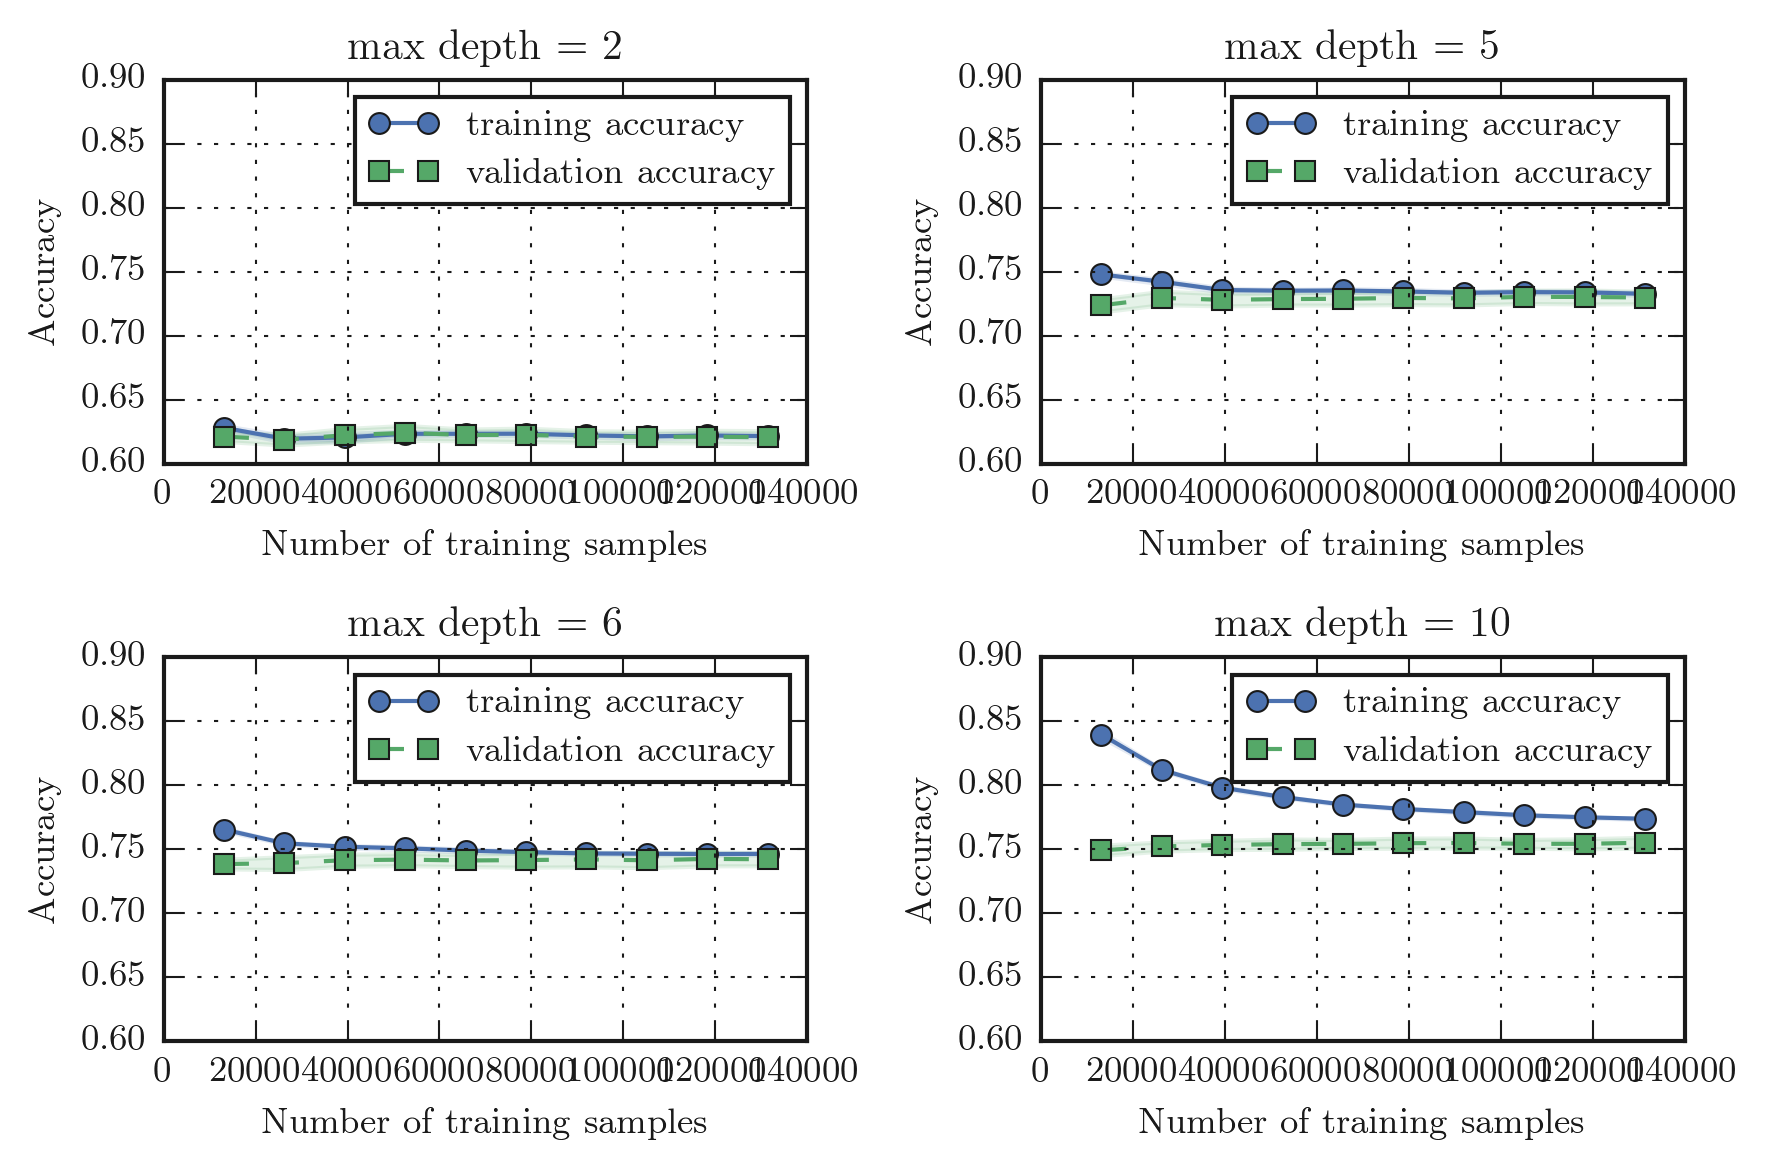

In [10]:
fig, axarr = plt.subplots(2, 2)
for max_depth, ax in zip([2, 5, 6, 10], axarr.flatten()):
    print('max_depth = {}'.format(max_depth))
    pipeline = comp.get_pipeline('RF')
    params = {'classifier__max_depth': max_depth}
    pipeline.set_params(**params)

    train_sizes, train_scores, test_scores =\
        learning_curve(estimator=pipeline,
                       X=X_train_sim,
                       y=y_train_sim,
                       train_sizes=np.linspace(0.1, 1.0, 10),
                       cv=10,
                       n_jobs=20,
                       verbose=0)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    ax.plot(train_sizes, train_mean,
             color='b', linestyle='-',
             marker='o', markersize=5,
             label='training accuracy')

    ax.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='b')

    ax.plot(train_sizes, test_mean,
             color='g', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    ax.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='g')

    ax.grid()
    ax.set_xlabel('Number of training samples')
    ax.set_ylabel('Accuracy')
    ax.set_title('max depth = {}'.format(max_depth))
    ax.set_ylim([0.6, 0.9])
    ax.legend()
plt.tight_layout()
plt.show()